In [1]:
# importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# dataset paths
data_path1 = '/kaggle/input/stuffs/data0.npy'
data_path2 = '/kaggle/input/stuffs/data1.npy'
data_path3 = '/kaggle/input/stuffs/data2.npy'

label_path1 = '/kaggle/input/stuffs/lab0.npy'
label_path2 = '/kaggle/input/stuffs/lab1.npy'
label_path3 = '/kaggle/input/stuffs/lab2.npy'

In [3]:
# loading the dataset
data1 = np.load(data_path1)
data2 = np.load(data_path2)
data3 = np.load(data_path3)

label1 = np.load(label_path1)
label2 = np.load(label_path2)
label3 = np.load(label_path3)

In [4]:
# printing the shape of the data
print('Data1 shape:', data1.shape, 'Label1 shape:', label1.shape)
print('Data2 shape:', data2.shape, 'Label2 shape:', label2.shape)
print('Data3 shape:', data3.shape, 'Label3 shape:', label3.shape)


Data1 shape: (10000, 40, 168) Label1 shape: (10000,)
Data2 shape: (10000, 40, 168) Label2 shape: (10000,)
Data3 shape: (10000, 40, 168) Label3 shape: (10000,)


In [5]:
# combining the datasets into 1
data = np.concatenate((data1, data2, data3), axis=0)
labels = np.concatenate((label1, label2, label3), axis=0)
print('Data shape:', data.shape, 'Labels shape:', labels.shape)

Data shape: (30000, 40, 168) Labels shape: (30000,)


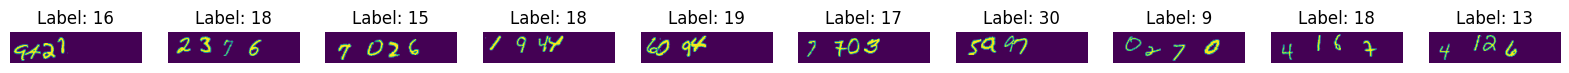

In [6]:
# displaying random images from the dataset
def display_images(data, label, indexes):
    fig, axes = plt.subplots(1, len(indexes), figsize=(20, 20))
    for i, j in enumerate(indexes):
        axes[i].imshow(data[j])
        axes[i].set_title('Label: ' + str(label[j]))
        axes[i].axis('off')
    plt.show()

num_images = 10
indexes = np.random.randint(0, data.shape[0], num_images)
display_images(data, labels, indexes)

In [7]:
# splitting the data into training and validation
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
print('X_train shape:', X_train.shape, 'y_train shape:', y_train.shape)
print('X_val shape:', X_val.shape, 'y_val shape:', y_val.shape)

X_train shape: (24000, 40, 168) y_train shape: (24000,)
X_val shape: (6000, 40, 168) y_val shape: (6000,)


In [8]:
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
from PIL import Image

# Custom Dataset
class NumberSumDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            # For grayscale, ensure the shape is (1, height, width)
            image = torch.tensor(image, dtype=torch.float32).unsqueeze(0) / 255.0

        label = torch.tensor(label, dtype=torch.float32)
        return image, label


In [9]:
# making dataloader for the dataset
import torch
from torch.utils.data import Dataset, DataLoader

train_dataset = NumberSumDataset(X_train, y_train)
val_dataset = NumberSumDataset(X_val, y_val)

train_batch_size = 32
val_batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=False)


In [10]:
# defining model class
import torch.nn as nn
import torch.nn.functional as F

# Attention Module
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv2 = nn.Conv2d(in_channels, in_channels // 8, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv4 = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.softmax = nn.Softmax(dim=-1)
        self.final_conv = nn.Conv2d(in_channels, in_channels, kernel_size=1)  # Residual enhancement

    def forward(self, x):
        batch_size, C, H, W = x.size()
        
        # Initial projections
        query = self.conv1(x).reshape(batch_size, -1, H * W).permute(0, 2, 1)  # (B, H*W, C//8)
        key = self.conv2(x).reshape(batch_size, -1, H * W)  # (B, C//8, H*W)
        value = self.conv3(x).reshape(batch_size, -1, H * W).permute(0, 2, 1)  # (B, H*W, C)

        # Attention map
        attention = self.softmax(torch.bmm(query, key))  # (B, H*W, H*W)
        attended_values = torch.bmm(attention, value).permute(0, 2, 1).reshape(batch_size, C, H, W)  # (B, C, H, W)

        # Enhance attention output with additional processing
        enhanced_attention = F.relu(self.conv4(attended_values))  # (B, C, H, W)

        # Add residual connection
        output = self.final_conv(enhanced_attention) + x
        return output


# CNN Model with Convolution Block, Attention and Pooling
class CNNWithAttention(nn.Module):
    def __init__(self, input_size=128, height=40, width=168, num_classes=1):
        super(CNNWithAttention, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Grayscale input (1 channel)
        self.pool1 = nn.MaxPool2d(2, 2)  # Downsample by 2

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # Downsample by 2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # Downsample by 2

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2, 2)  # Downsample by 2

        # Additional convolutional block
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(2, 2)  # Downsample by 2

        # Attention module
        self.attention = AttentionModule(512)

        # Fully connected layers
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, height, width)
            dummy_output = self._forward_features(dummy_input)
            self.flattened_size = dummy_output.numel()  # Compute size after feature extraction

        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc2 = nn.Linear(512, num_classes)

    # Uptil attention
    def _forward_features(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = self.pool5(F.relu(self.conv5(x)))
        x = self.attention(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.reshape(x.size(0), -1)  # Flatten 
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [11]:
# loading the best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = CNNWithAttention().to(device)
best_model.load_state_dict(torch.load("/kaggle/input/cnnattent/pytorch/default/1/best_model (3).pth"))

<ipython-input-11-d41745aa7e67>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("/kaggle/input/cnnattent/pytorch/default/1/best_model 

<All keys matched successfully>

In [12]:
# calculating accuracy on train and validation set
def evaluate_model(model,dataloader, threshold=0.5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Model predictions
            outputs = model(images).squeeze()

            # Calculate differences and compare with the threshold
            differences = torch.abs(outputs - labels)
            correct_predictions += torch.sum(differences < threshold).item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples * 100
    return accuracy

threshold = 0.5
train_accuracy = evaluate_model(best_model, train_dataloader, threshold)
val_accuracy = evaluate_model(best_model, val_dataloader, threshold)
print(f"Train Accuracy (Threshold {threshold}): {train_accuracy:.2f}%")
print(f"Validation Accuracy (Threshold {threshold}): {val_accuracy:.2f}%")

Train Accuracy (Threshold 0.5): 96.77%
Validation Accuracy (Threshold 0.5): 75.25%


In [13]:
# calculating the loss on the train and validation set
def calculate_loss(model, dataloader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Model predictions
            outputs = model(images).squeeze()

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * labels.size(0)
            total_samples += labels.size(0)

    return total_loss / total_samples

criterion = nn.MSELoss()
train_loss = calculate_loss(best_model, train_dataloader, criterion)
val_loss = calculate_loss(best_model, val_dataloader, criterion)
print(f"Train Loss: {train_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

Train Loss: 0.0527
Validation Loss: 0.5827


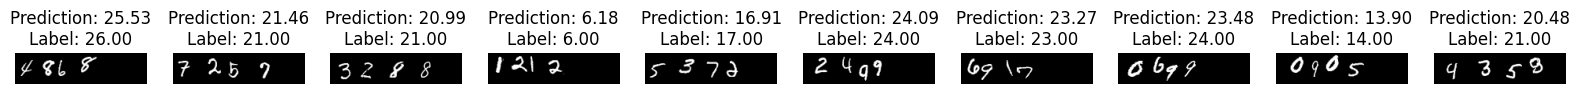

In [15]:
import random

def inference_on_random_images(model, dataset, num_images=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = model.to(device)
    model.eval()

    images = []
    predictions = []
    labels = []

    # Randomly select indices from the dataset
    random_indices = random.sample(range(len(dataset)), num_images)

    with torch.no_grad():
        for idx in random_indices:
            image, label = dataset[idx]  # Access random image from the dataset
            image = image.unsqueeze(0).to(device)  # Add batch dimension
            label = label.to(device)

            # Model predictions
            output = model(image).squeeze()

            images.append(image.cpu())
            predictions.append(output.cpu())
            labels.append(label.cpu())

    return images, predictions, labels

# Run inference on 10 random images
num_images = 10
images, predictions, labels = inference_on_random_images(best_model, val_dataset, num_images)

# Display the images with predictions
def display_images_with_predictions(images, predictions, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 20))
    for i in range(len(images)):
        image = images[i].squeeze().numpy()
        prediction = predictions[i].item()  # Convert tensor to scalar
        label = labels[i].item()  # Convert tensor to scalar

        axes[i].imshow(image, cmap="gray")  # Use grayscale for single-channel images
        axes[i].set_title(f"Prediction: {prediction:.2f}\nLabel: {label:.2f}")
        axes[i].axis('off')
    plt.show()

display_images_with_predictions(images, predictions, labels)
